# Importando bibiotecas necessárias

In [3]:
import io
import os
import boto3
import sagemaker
import pandas as pd
import numpy  as np
import seaborn as sns
import sagemaker as Session
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
from sagemaker import image_uris
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Tratamento da base de dados

In [5]:
# Reading the problem database and visualization
hotelReservations = pd.read_csv('hotelReservations.csv')
hotelReservations

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [6]:
# Verification if there are null values within the dataset.
hotelReservations.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [7]:
# Addition of the column that will be used for classification, initially with value 0 on all lines.
hotelReservations.insert(0, 'label_avg_price_per_room', 0)

In [8]:
# Filling of the new column according to the values of the 'Avg_Price_Per_Room' column.
for i in range(len(hotelReservations)):
    if (hotelReservations['avg_price_per_room'][i] <= 85):
        hotelReservations.loc[i, 'label_avg_price_per_room'] = 0
    elif (85 < hotelReservations['avg_price_per_room'][i] < 115):
        hotelReservations.loc[i, 'label_avg_price_per_room'] = 1
    else:
        hotelReservations.loc[i, 'label_avg_price_per_room'] = 2

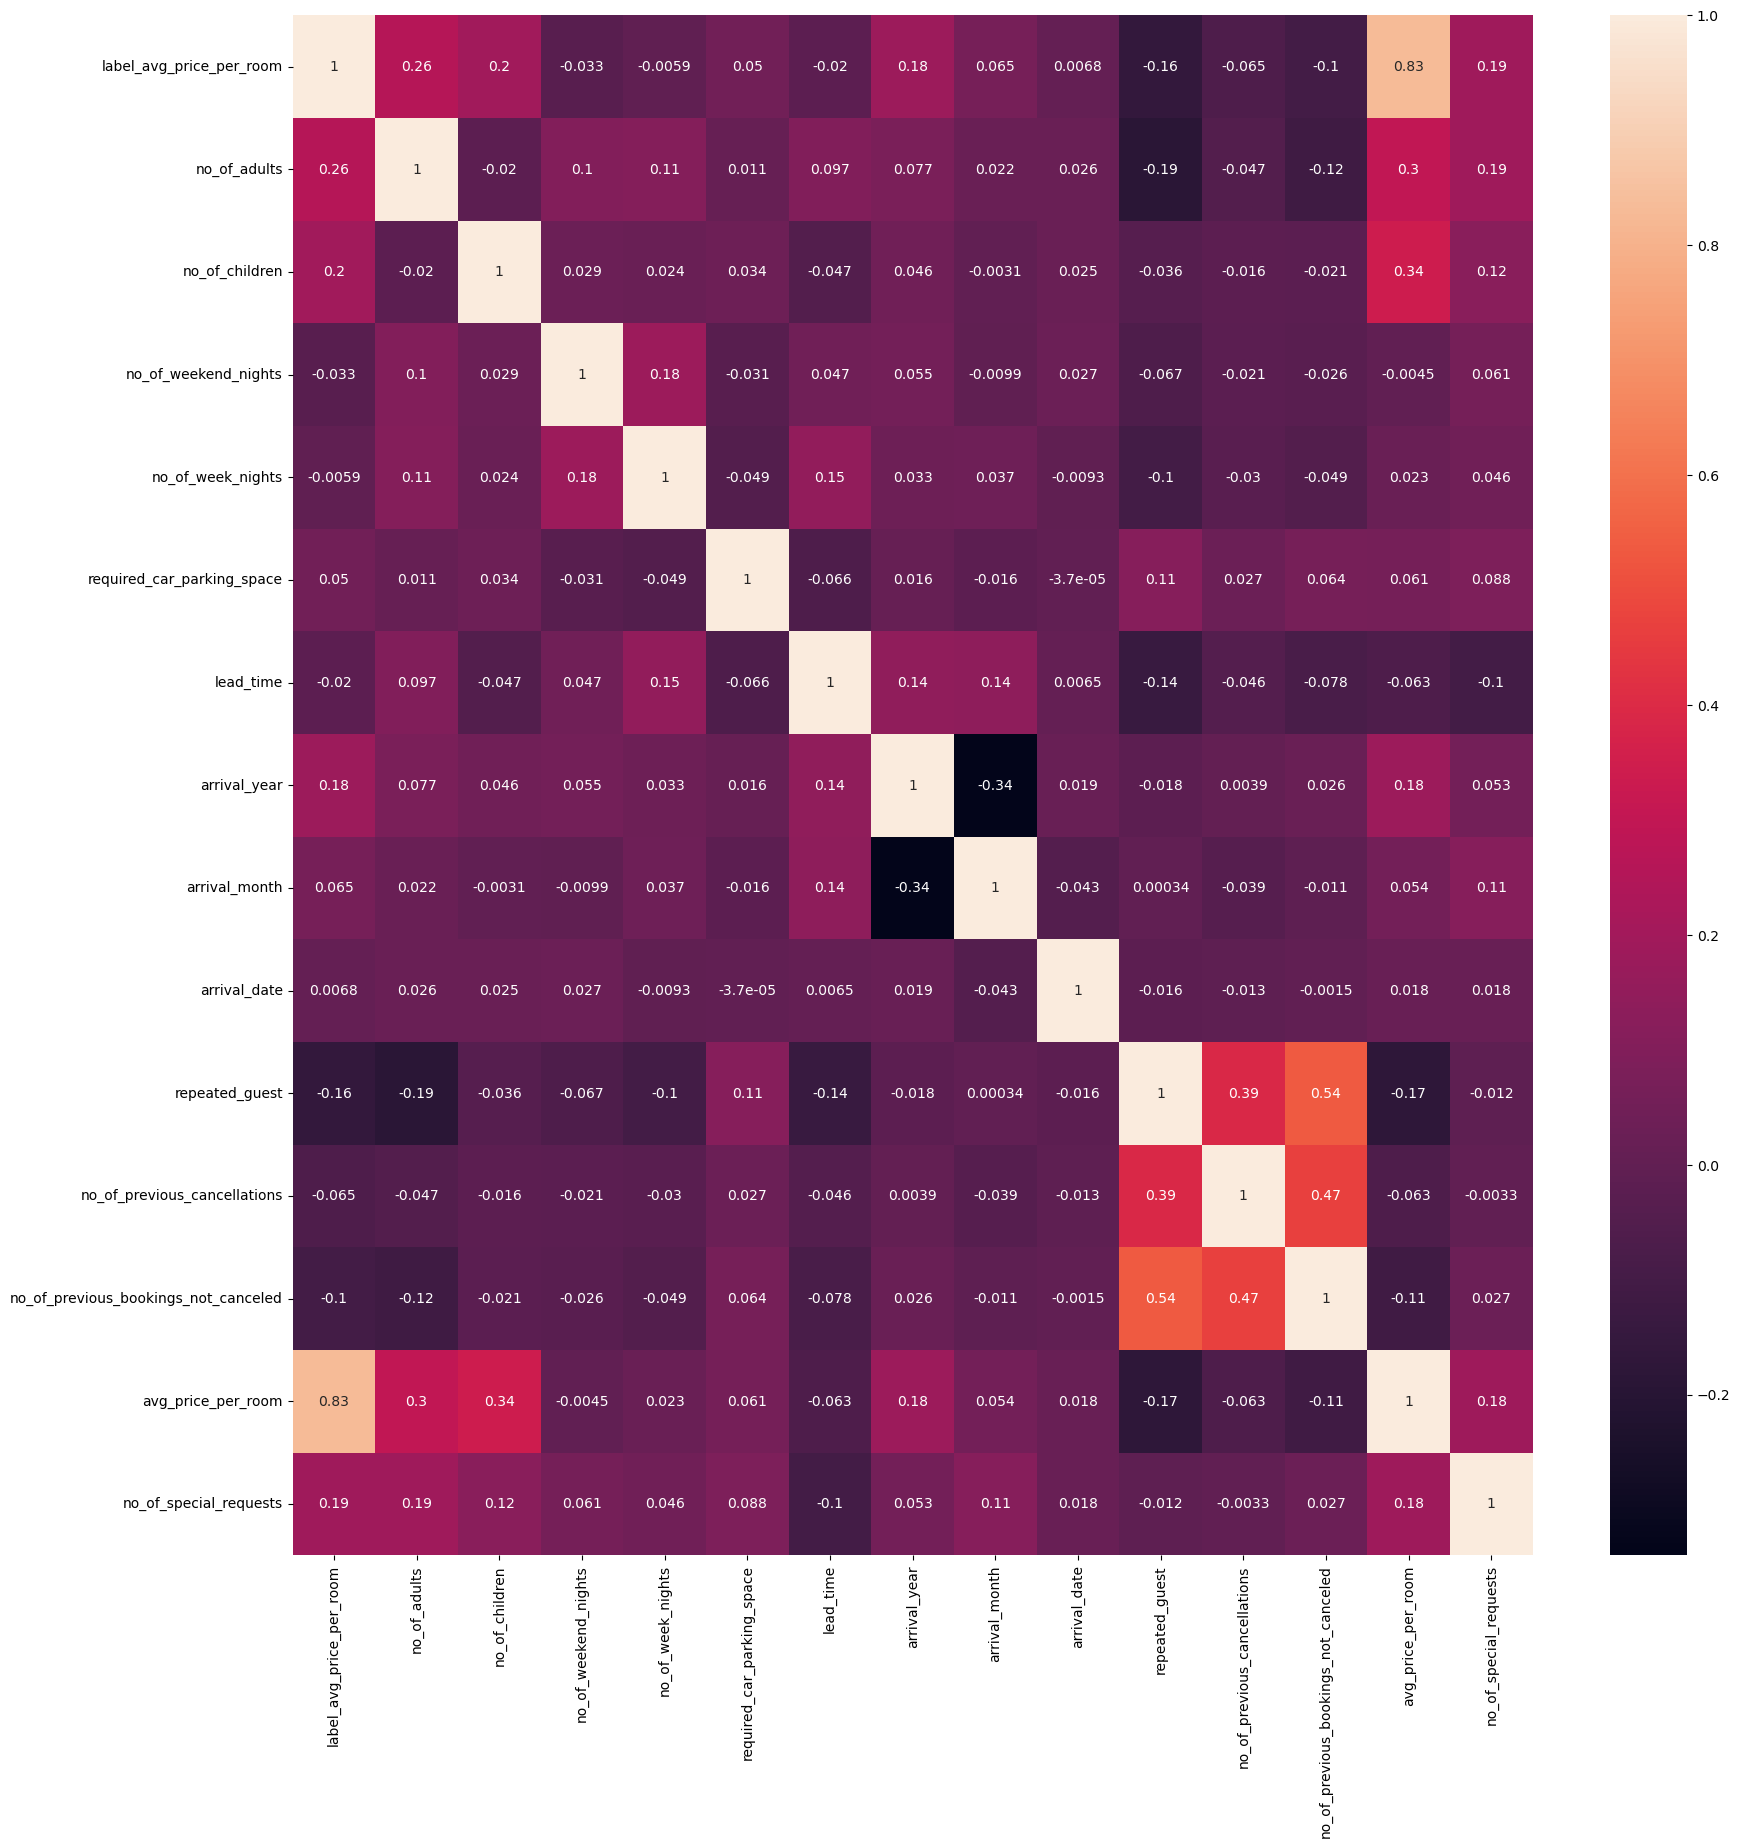

In [9]:
figure = plt.figure(figsize=(20,20))
sns.heatmap(hotelReservations.corr(), annot=True)

In [10]:
# 'AVG_PRICE_PER_ROOM' and IDS column deletion, given that this column does not affect data training.
hotelReservations = hotelReservations.drop(columns = ['avg_price_per_room'])
hotelReservations = hotelReservations.drop(columns = ['Booking_ID'])

In [11]:

hotelReservations

,label_avg_price_per_room,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,no_of_special_requests,booking_status
0,0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,0,Not_Canceled
1,1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,1,Not_Canceled
2,0,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,0,Canceled
3,1,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,0,Canceled
4,1,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,2,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,1,Not_Canceled
36271,1,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,2,Canceled
36272,1,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,2,Not_Canceled
36273,1,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,0,Canceled


In [12]:
# Visualization of all categories within the categorical database columns for later treatment.
print(np.unique(hotelReservations['type_of_meal_plan']))
print(np.unique(hotelReservations['room_type_reserved']))
print(np.unique(hotelReservations['market_segment_type']))
print(np.unique(hotelReservations['booking_status']))

['Meal Plan 1' 'Meal Plan 2' 'Meal Plan 3' 'Not Selected']
['Room_Type 1' 'Room_Type 2' 'Room_Type 3' 'Room_Type 4' 'Room_Type 5'
 'Room_Type 6' 'Room_Type 7']
['Aviation' 'Complementary' 'Corporate' 'Offline' 'Online']
['Canceled' 'Not_Canceled']


In [14]:
# Treatment of categorical columns with the Get_Dummies function to transform them into category columns.
hotelReservations = pd.get_dummies(hotelReservations, prefix = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type','booking_status'],
                                  columns = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type','booking_status'])

In [37]:
# Verification If there are null values within the database.
hotelReservations.isnull().sum()

label_avg_price_per_room                0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
required_car_parking_space              0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
no_of_special_requests                  0
type_of_meal_plan_Meal Plan 1           0
type_of_meal_plan_Meal Plan 2           0
type_of_meal_plan_Meal Plan 3           0
type_of_meal_plan_Not Selected          0
room_type_reserved_Room_Type 1          0
room_type_reserved_Room_Type 2          0
room_type_reserved_Room_Type 3          0
room_type_reserved_Room_Type 4          0
room_type_reserved_Room_Type 5          0
room_type_reserved_Room_Type 6    

In [16]:
# Separation of the Training Bases and Test for XGboost (70%/30%).
trainBase = hotelReservations.iloc[0:25392, :]
testBase  = hotelReservations.iloc[25392:, :]
trainBase.shape, testBase.shape

((25392, 32), (10883, 32))

In [17]:
# Creation of test variables x and y, where x will be all the different columns from which we seek to categorize
# and the y test variable has the expected categories.
te_x = testBase.iloc[:, 1:len(hotelReservations)].values
te_y = testBase.iloc[:, 0].values

print(f'Variável de teste x: {te_x}')
print(f'Variável de teste y: {te_y}')

Variável de teste x: [[3 0 2 ... 1 0 1]
 [1 0 1 ... 0 0 1]
 [1 0 0 ... 1 0 1]
 ...
 [2 0 2 ... 1 0 1]
 [2 0 0 ... 1 1 0]
 [2 0 1 ... 0 0 1]]
Variável de teste y: [2 1 0 ... 1 1 2]


In [18]:
trainBase.to_csv('hotelReservations_train_xgboost.csv', header = False, index = False)
testBase.to_csv('hotelReservations_test_xgboost.csv' , header = False, index = False)

# Configurações SageMaker

In [ ]:
# Declaration of the variables that will be used during the training
session    = sagemaker.Session()
role       = sagemaker.get_execution_role()
bucket     = 'cristofercursoawssagemaker'
key_test   = 'hotelReservations_testData_xgboost'
key_train  = 'hotelReservations_trainData_xgboost'
modelDir   = 'modelosSprint5/hotelReservations/xgboost'
datasetDir = 'datasetsSprint5/hotelReservations'

s3_train_data   = f's3://{bucket}/{datasetDir}/train/{key_train}'
s3_test_data    = f's3://{bucket}/{datasetDir}/test/{key_test}'
output_location = f's3://{bucket}/{modelDir}/output'

In [21]:
with open('hotelReservations_train_xgboost.csv', 'rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(datasetDir, 'train', key_train)).upload_fileobj(f)

In [22]:
with open('hotelReservations_test_xgboost.csv', 'rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(datasetDir, 'test', key_test)).upload_fileobj(f)

# Tuning

In [24]:
container = image_uris.retrieve(framework = 'xgboost', region = boto3.Session().region_name, version = 'latest')

In [25]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "2",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "300",
          "MinValue": "50",
          "Name": "num_round"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 12,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:merror",
      "Type": "Minimize"
    }
  }

In [26]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_train_data
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_test_data
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,modelDir)
    },
    "ResourceConfig": {
      "InstanceCount": 2,
      "InstanceType": "ml.m5.2xlarge",
      "VolumeSizeInGB": 20
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "merror",
      "num_class": "3",
      "objective": "multi:softmax",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [27]:
smclient = boto3.client('sagemaker')
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = "xgboosttuninghotelssprint5",
                                          HyperParameterTuningJobConfig = tuning_job_config,
                                          TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:994992571997:hyper-parameter-tuning-job/xgboosttuninghotelssprint5',
 'ResponseMetadata': {'RequestId': 'f12e715a-31e5-41ba-b026-70b1e73b4a27',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f12e715a-31e5-41ba-b026-70b1e73b4a27',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '127',
   'date': 'Wed, 16 Aug 2023 19:42:15 GMT'},
  'RetryAttempts': 0}}

# Construção do modelo

In [28]:
train_input      = sagemaker.inputs.TrainingInput(s3_data = s3_train_data, content_type = 'csv', s3_data_type = 'S3Prefix')
validation_input = sagemaker.inputs.TrainingInput(s3_data = s3_test_data, content_type = 'csv', s3_data_type = 'S3Prefix')
data_channels    = {'train': train_input, 'validation': validation_input}

In [29]:
xgboost_tuning = sagemaker.estimator.Estimator(image_uri = container,
                                        role = role, 
                                        instance_count = 2, 
                                        instance_type = 'ml.m5.2xlarge',
                                        output_path = output_location,
                                        sagemaker_session = session)

xgboost_tuning.set_hyperparameters(_tuning_objective_metric = "validation:merror",
                                   eval_metric = "merror",
                                   num_class = 3,
                                   objective = "multi:softmax",
                                   num_round = 239, 
                                   eta = 0.847264446705649,
                                   min_child_weight = 2.599706832170389,
                                   alpha = 1.1952745178331554, 
                                   tweedie_variance_power = 1.4,
                                   rate_drop = 0.3)



xgboost_tuning.fit(data_channels)

INFO:sagemaker:Creating training-job with name: xgboost-2023-08-16-20-08-31-624


2023-08-16 20:08:31 Starting - Starting the training job...
2023-08-16 20:08:47 Starting - Preparing the instances for training......
2023-08-16 20:09:57 Downloading - Downloading input data...
2023-08-16 20:10:32 Training - Downloading the training image...
2023-08-16 20:10:42 Training - Training image download completed. Training in progress..Arguments: train
[2023-08-16:20:11:01:INFO] Running distributed xgboost training.
[2023-08-16:20:11:01:INFO] Number of hosts: 2, master IP address: 10.0.135.69, host IP address: 10.0.135.69.
[2023-08-16:20:11:01:INFO] Finished Yarn configuration files setup.
starting namenode, logging to /opt/amazon/hadoop/logs/hadoop--namenode-ip-10-0-135-69.ec2.internal.out
Arguments: train
[2023-08-16:20:11:01:INFO] Running distributed xgboost training.
[2023-08-16:20:11:01:INFO] Number of hosts: 2, master IP address: 10.0.135.69, host IP address: 10.0.150.169.
[2023-08-16:20:11:01:INFO] Finished Yarn configuration files setup.
starting datanode, logging to /

In [30]:
xgboost_classifier_tuning = xgboost_tuning.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-08-16-20-16-40-698
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-08-16-20-16-40-698
INFO:sagemaker:Creating endpoint with name xgboost-2023-08-16-20-16-40-698


-------!

# Testes

In [31]:
xgboost_classifier_tuning.serializer = CSVSerializer()

In [32]:
previsoes = np.array(xgboost_classifier_tuning.predict(te_x).decode('utf-8').split(',')).astype(np.float32)
previsoes

array([2., 1., 0., ..., 1., 1., 2.], dtype=float32)

In [33]:
cm = confusion_matrix(te_y, previsoes)
cm

array([[2895,  411,   52],
       [ 364, 3365,  292],
       [  32,  337, 3135]])

In [34]:
accuracy_score(te_y, previsoes)

0.8632729945787008

In [35]:
print(classification_report(te_y, previsoes))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3358
           1       0.82      0.84      0.83      4021
           2       0.90      0.89      0.90      3504

    accuracy                           0.86     10883
   macro avg       0.87      0.86      0.87     10883
weighted avg       0.86      0.86      0.86     10883

